# Linear Regression
Salary Prediction

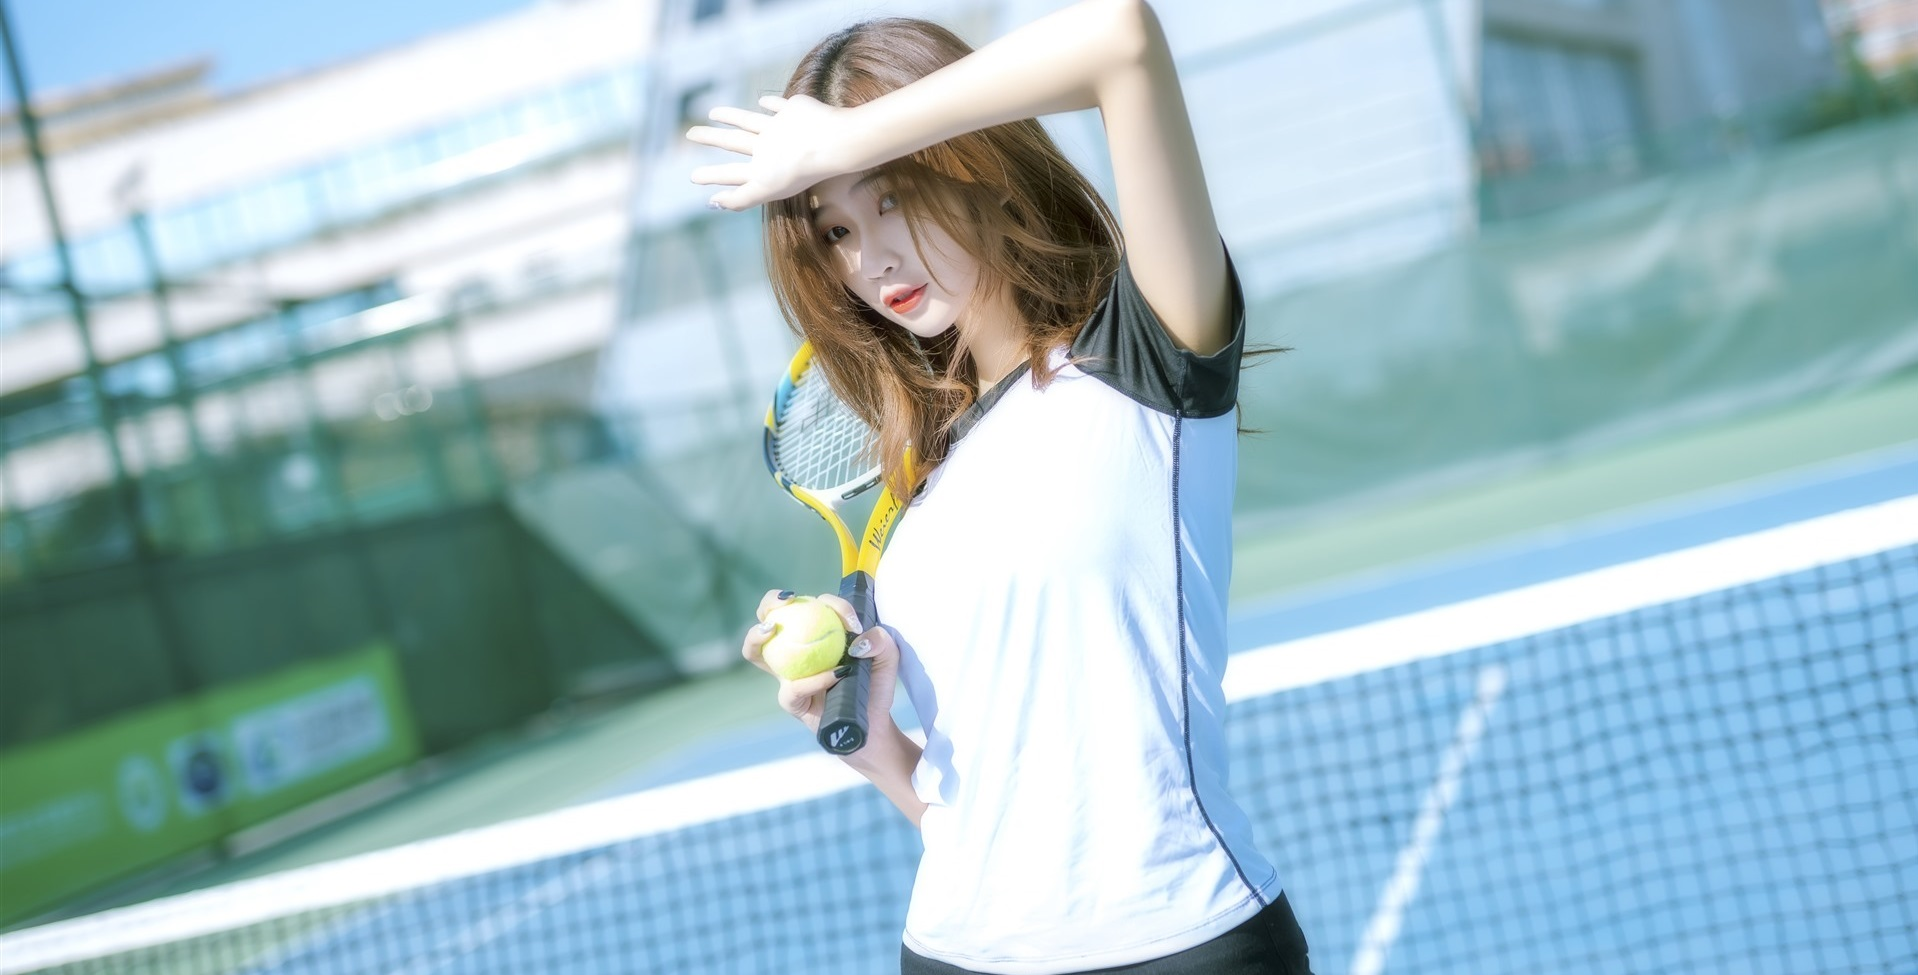

Data source: [Association of Tennis Professionals (ATP)](https://en.wikipedia.org/wiki/Association_of_Tennis_Professionals)

## Tennis Ace




`Project Goals`
- Create a linear regression model that predicts the earnings of tennis players based on their playing habits. By analyzing and modeling the Association of Tennis Professionals (ATP) data.

`Target/Outcomes`
- Winnings: total winnings in USD($) in a year


`Data Dictionary:`

--Not Available--

## Content
1. Import and Load Data
2. Preliminary Linear Regression
   - 2.1 Building a Linear  Regression Model
   - 2.2 Model Accuracy
3. Feature Selection
   - 3.1 Wrapper Methods
   - 3.2 RFE
   - 3.3 Select K best
   - 3.4 Further Observation 
4. Final Linear Regression 
   - 4.1 Building a Linear  Regression Model
   - 4.2 Final Regression Evaluation
   - 4.3 Test Run
5. Conclusion   

***

#  1.Import and Load Data

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, skew

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import mutual_info_regression, RFE, SelectKBest, f_regression
from functools import partial

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
# load data
df = pd.read_csv('tennis_stats.csv')
print(df.shape)
df.head(2)

(1721, 24)


,Player,Year,FirstServe,FirstServePointsWon,FirstServeReturnPointsWon,SecondServePointsWon,SecondServeReturnPointsWon,Aces,BreakPointsConverted,BreakPointsFaced,BreakPointsOpportunities,BreakPointsSaved,DoubleFaults,ReturnGamesPlayed,ReturnGamesWon,ReturnPointsWon,ServiceGamesPlayed,ServiceGamesWon,TotalPointsWon,TotalServicePointsWon,Wins,Losses,Winnings,Ranking
0,Pedro Sousa,2016,0.88,0.50,0.38,0.50,0.39,0,0.14,7,7,0.43,2,9,0.11,0.38,8,0.50,0.43,0.50,1,2,39820,119
1,Roman Safiullin,2017,0.84,0.62,0.26,0.33,0.07,7,0.00,7,0,0.57,1,9,0.00,0.20,9,0.67,0.41,0.57,0,1,17334,381


# 2. Preliminary Linear Regression

We will start by building a Linear Regression with all the features available and compare it later to our final logistic model.

### 2.1 Building a Linear  Regression Model

##### Split the data into `X` and `y`

In [3]:
y = df['Winnings']
X = df.drop(columns=['Winnings', 'Player'])

##### Train Test split
Spliting our data to training 70% and testing 30%.

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, y,  test_size = 0.30, random_state = 0)

##### Normalize the Data
Our features(X) must be in the same scale

In [5]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

##### Linear  Regression Model

In [6]:
lr = LinearRegression()

##### Fit the model

Use the `.fit()` method on `lr` to fit the model to `X` and `y`.

In [7]:
lr.fit(x_train, y_train)

LinearRegression()

### 2.2 Model accuracy



`Note:`
  - Overfitting, It fits the training data well but performs significantly worse on test data.
  - When data is overfit, we do regularization (LAsso, Ridge)

##### R2 score (measure of goodness of the model)

Important formula:

where:
- y = actual values

- ŷ = predicted value

   - r2 = 1 - (tss / rss)
   - tss = sum (y - mean_of_y)^2
   - rss = sum(y - ŷ)^2 



In [8]:
print('Training Score: ' + str(lr.score(x_train,y_train)))
print('Testing Score: ' + str(lr.score(x_test,y_test)))

Training Score: 0.8931239790692806
Testing Score: 0.8909760018805483


##### Mean Squared Error (Training and Testing Dataset)

In [9]:
# high difference is an indicator of overfitting

# prediction from training set
pred_train = lr.predict(x_train)
# prediction from testing set
pred_test = lr.predict(x_test)

# MSE, prediction and actual from training set
MSE_train = np.mean((pred_train - y_train)**2)
print("Training Error: ", MSE_train)

# MSE, prediction and actual from testing set
MSE_test = np.mean((pred_test - y_test)**2)
print("Testing Error: ", MSE_test)

print("Difference %: ", abs((MSE_train - MSE_test) / MSE_train)  )

Training Error:  7143338538.850752
Testing Error:  6216637074.812809
Difference %:  0.12972946179126968


# 3. Feature Selection
Finding the most suitable features to improve our model score/performance.

### 3.1 Wrapper Methods
Now that we've created a linear regression model and evaluated its performance, we're ready to do some feature selection.

First lets define a variables of our feature selection methods.

1. `number_of_features` the number of features
2. `scoring_method`;
 - for classifiers {'accuracy', 'f1', 'precision', 'recall', 'roc_auc'}
 - for regressors  {'r2', ‘max_error’,'neg_mean_squared_error', 'median_absolute_error'}
 
Documentation; https://scikit-learn.org/stable/modules/model_evaluation.html 
 
 
Note: We're fitting the the orignal X and y variables here instead of the training and testing data set. 

We will us `r2` as our scoring method.

In [10]:
# Input variable here:
number_of_features = 8
scoring_method = 'r2'

##### Sequencial Forward Floating Selection

In [37]:
sffs = SFS(lr,
        k_features=number_of_features,
        forward= True,
        floating= True,
        scoring=scoring_method,
        cv=0)

# Note: our X values here are not standarized or
# does sffs automatically standarized our features?
# should I just fit the x_train, y_train here?
# (code edited from fit to fit_transform 10/13/22 -alyx)
sffs.fit_transform(X, y)
print('SFFS selected features:')

# Saving a copy of sffs selected features in a list variable
X_sffs = list(sffs.subsets_[number_of_features]['feature_names'])

print(X_sffs)    
print('\n' + str(scoring_method) + ': ' +  str(sffs.subsets_[number_of_features]['avg_score']))

SFFS selected features:
['Year', 'BreakPointsFaced', 'BreakPointsOpportunities', 'DoubleFaults', 'ServiceGamesPlayed', 'Wins', 'Losses', 'Ranking']

r2: 0.8923341769921913


##### Sequencial Backward Floating Selection

In [38]:
sbfs = SFS(lr,
            k_features=1,
            forward= False,
            floating= True,
            scoring=scoring_method,
            cv=0)
sbfs.fit_transform(X, y)
print('SBFS selected features:')

# Saving a copy of sbfs selected features in a list variable
X_sbfs = list(sbfs.subsets_[1]['feature_names'])

print(X_sbfs)
print('\n' + str(scoring_method) + ': ' +  str(sbfs.subsets_[1]['avg_score']))

SBFS selected features:
['Wins']

r2: 0.8341119961391337


`Wins` has the higest r2 score.

#### Visualize SFFS and SBFS

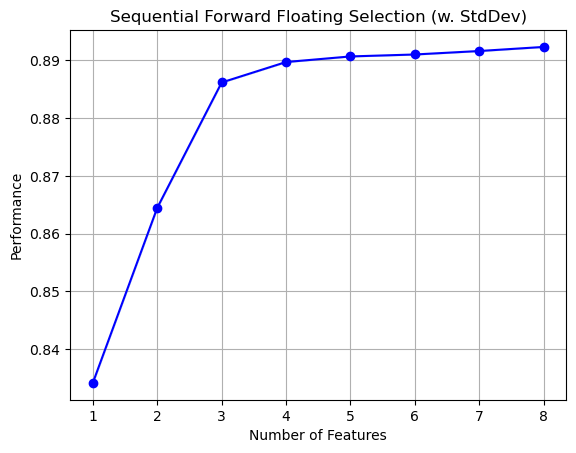

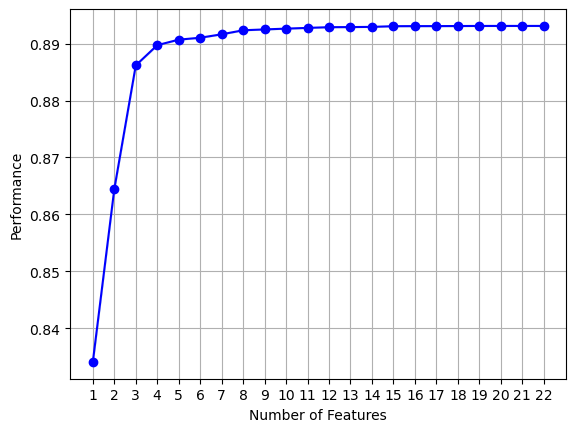

In [43]:
# Visualize sffs
# Visualize in DataFrame (Optional, Uncomment to view)
# pd.DataFrame.from_dict(ssfs.get_metric_dict()).T

fig1 = plot_sfs(sffs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Floating Selection (w. StdDev)')
plt.grid()
plt.show()

#Visualize sbfs
fig2 = plot_sfs(sbfs.get_metric_dict(), kind='std_dev')
plt.title('')
plt.grid()
plt.show()

The graph shows that there's not much variation from using 8 to 21 features though theres is a very very tiny increase using all the features, it's not enough justification and using all may lead to redundant information. We can simplify by just using 8 features instead. 

### 3.2 RFE
Ranking `features by importance`, discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains.

Before doing applying recursive feature elimination it is necessary to standardize the data.

In [45]:
# Setting a varible 'X_standard' so that our original X features will remain unaffected incase we re-run this code
X_standard = StandardScaler().fit_transform(X)
    
rfe = RFE(lr, n_features_to_select=number_of_features)
    
rfe.fit(X_standard,y)
    
rfe_features = [f for (f, support) in zip(X, rfe.support_) if support]
print('RFE selected features:')
X_rfe = rfe_features
print(X_rfe)
print('\nrfe score: '+ str(rfe.score(X_standard,y)))

RFE selected features:
['Year', 'BreakPointsFaced', 'BreakPointsOpportunities', 'DoubleFaults', 'ServiceGamesPlayed', 'Wins', 'Losses', 'Ranking']

rfe score: 0.8923341769921913


### 3.3 SelectKBest
We will be using the `f_regression` and `mutual_info_regression` for this test

Select K Best most common test methods;

`f_classif`
ANOVA F-value between label/feature for classification tasks.

`mutual_info_classif`
Mutual information for a discrete target.

`chi2`
Chi-squared stats of non-negative features for classification tasks.

`f_regression`
F-value between label/feature for regression tasks.

`mutual_info_regression`
Mutual information for a continuous target.

#### SelectKBest f_regression

In [50]:
# because we want to specify additional arguments (random_state=0) 
# besides the features and targets inputs, we’ll need the help of the partial()
# score_function = partial(test_method, random_state=0)
selection = SelectKBest(score_func = f_regression, k = number_of_features)
 
# fit the fata    
selection.fit_transform(X, y)

X_f_regression = X[X.columns[selection.get_support(indices=True)]]
X_f_regression = list(X_f_regression)
X_f_regression

['Aces',
 'BreakPointsFaced',
 'BreakPointsOpportunities',
 'DoubleFaults',
 'ReturnGamesPlayed',
 'ServiceGamesPlayed',
 'Wins',
 'Losses']

#### SelectKBest mutual_info_regression

In [51]:
selection = SelectKBest(score_func = mutual_info_regression, k = number_of_features)
 
# fit the fata    
selection.fit_transform(X, y)

# saving a copy of mutual_info_classifslected features in a list
X_mutual_info_regression = X[X.columns[selection.get_support(indices=True)]]
X_mutual_info_regression = list(X_mutual_info_regression)
X_mutual_info_regression

['Aces',
 'BreakPointsFaced',
 'BreakPointsOpportunities',
 'DoubleFaults',
 'ReturnGamesPlayed',
 'ServiceGamesPlayed',
 'Wins',
 'Losses']

### 3.4 Further Observation

Almost half of our features are corellated to our target. However we want to minimize our features to avoid redundant information and multicolinearity as possible.
As observed our selection methods accept the `losses` feature which in contrast with our general knowledge. We expect the opposite.

Lets view it in a scatter plot.

Text(0, 0.5, 'Winnings')

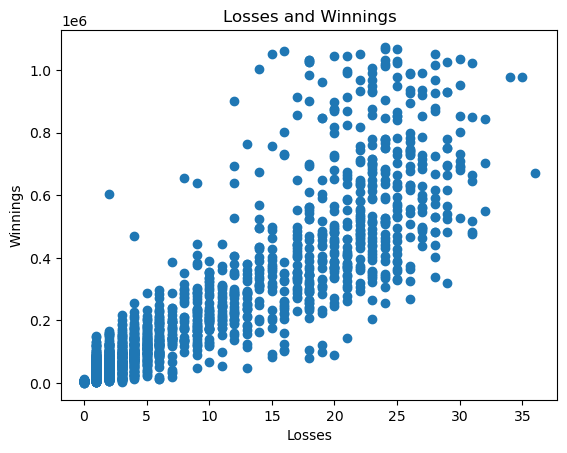

In [52]:
plt.scatter(df['Losses'], df['Winnings'])
plt.title('Losses and Winnings')
plt.xlabel('Losses')
plt.ylabel('Winnings')

In [53]:
corr, p = pearsonr(df['Losses'], df['Winnings'])
corr, p

(0.8692767614021005, 0.0)

As seen in the graph, `Losses` is 86.92%  correlated to `Winnings`. I suspect that number of losses and winnings contribute to overall number of `ServiceGamesPlayed`. 

The graph below show's the correlation between wins, losses and service games played(number of game of a player).

Text(0, 0.5, 'Wins')

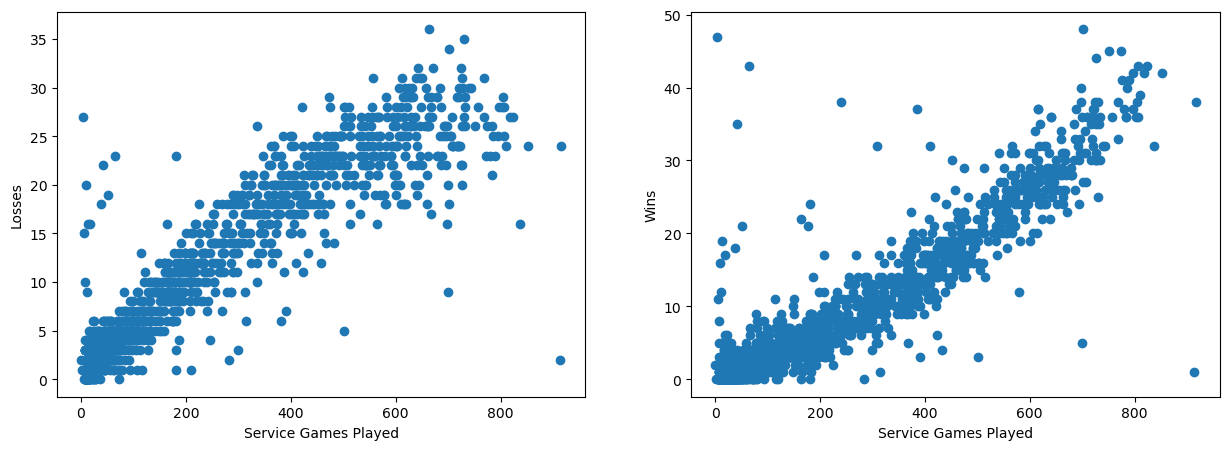

In [54]:
# show plot
plt.figure(figsize=(15, 5)) 

ax1 = plt.subplot(1,2,1)
plt.scatter(df['ServiceGamesPlayed'], df['Losses'])
plt.xlabel('Service Games Played')
plt.ylabel('Losses')

ax1 = plt.subplot(1,2,2)
plt.scatter(df['ServiceGamesPlayed'], df['Wins'] )
plt.xlabel('Service Games Played')
plt.ylabel('Wins')

The number of `ServiceGamesplayed` produces the number of `Wins` and `Losses` affecting our target `Winnings` value. This is an example of duplicate information, `we can drop the one that has lower correlation to our target`. We can view that information with the use of correlation heapmap.

<AxesSubplot:>

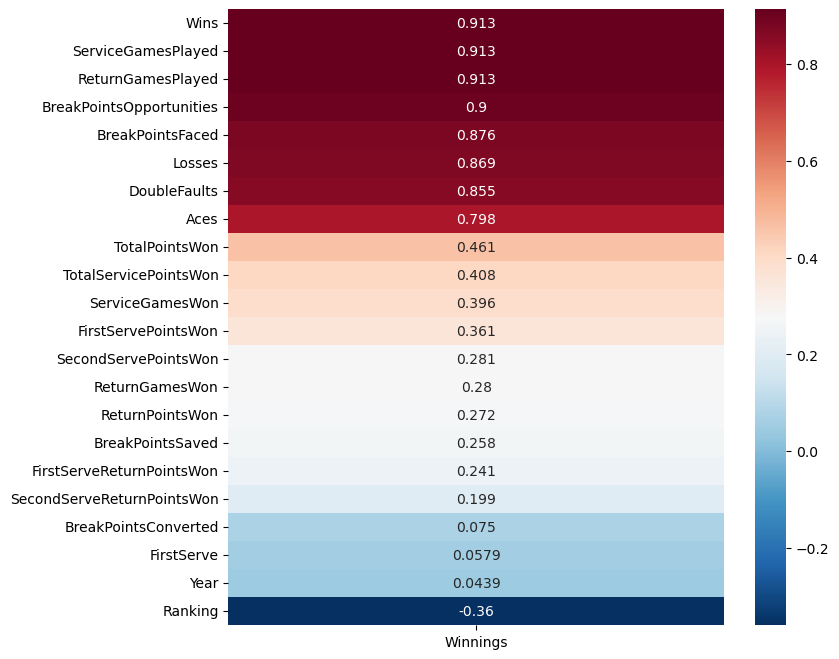

In [55]:
# Correlation between features and target
plt.figure(figsize=(8, 8)) 
corr_matrix = df.corr()
 
# Isolate the column corresponding to `Winnings`
corr_target = corr_matrix[['Winnings']].drop(labels=['Winnings'])
corr_target = corr_target.sort_values(by=['Winnings'], ascending=False)

sns.heatmap(corr_target, annot=True, fmt='.3', cmap='RdBu_r')

The correlation table clearly display that `Wins` has the higher correlation to `Winnings` than `losses`.
We will drop losses in this case and replace it with `ReturnGamesPlayed`.

Creating our own feature list:

In [56]:
X_sffs

['Year',
 'BreakPointsFaced',
 'BreakPointsOpportunities',
 'DoubleFaults',
 'ServiceGamesPlayed',
 'Wins',
 'Losses',
 'Ranking']

In [57]:
X_my_list =['Year',
            'BreakPointsFaced',
            'BreakPointsOpportunities',
            'DoubleFaults',
            'ServiceGamesPlayed',
            'Wins',
#             'Losses',
            'Ranking']

# 4. Final Linear Regression
Linear Regression with `selected features`.

### 4.1 Building Final Logistic Regression
So far we have six different list of selected features, What we can do for now is to try each list and find the one which has the highest scores.

In this case we will using the `X_my_list`.
1. X_my_list
2. X_sffs
3. X_sbfs
4. X_rfe
5. X_f_regression
6. X_mutual_info_regression

In [58]:
X = df[X_my_list]
y = df['Winnings']

In [59]:
x_train, x_test, y_train, y_test = train_test_split(X, y,  test_size = 0.30, random_state = 0)

In [60]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

lr = LinearRegression()

lr.fit(x_train, y_train)

LinearRegression()

We have narrowed down our features from 21 to just 8 without sacrificing too much of our model performance.

### 4.2 Final Regression Evaluation

Our regresion model score.

In [61]:
# r2 score
# r2 ( 1- (TSS / RSS)

# TSS = how far each observation from mean 
#       sum of (each actual - its mean value)^2

# RSS = sum squared residual (lower the better) 

print(lr.score(x_train,y_train))
print(lr.score(x_test,y_test))

0.8913335512852711
0.8890348563475029


In [62]:
# Mean squared error
# (actual - predicted)^2 / number of observation
# high difference is an indicator of overfitting

#Training Error
pred_train = lr.predict(x_train)
MSE_train = np.mean((pred_train - y_train)**2)
print("Training Error: ", MSE_train)

# 2. Testing Error
pred_test = lr.predict(x_test)
MSE_test = np.mean((pred_test - y_test)**2)
print("Testing Error: ", MSE_test)

print("Difference %: ", abs((MSE_train - MSE_test) / MSE_train)  )

Training Error:  7263006465.099948
Testing Error:  6327322772.4251375
Difference %:  0.12882870160875373


Using just 8 features our final regression model score has no significant difference from our preliminary model with  all the features.

### Visualization of actual and predicted earnings.

In [63]:
y_predict = lr.predict(x_test)

Text(0, 0.5, 'Predicted Winnings')

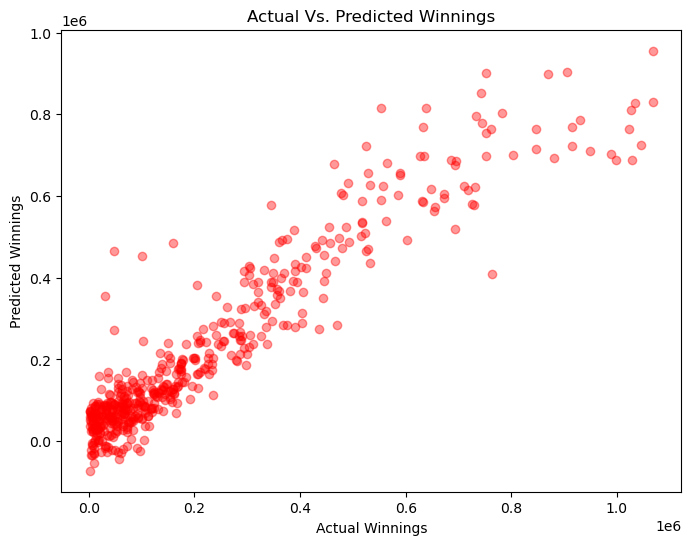

In [64]:
# visualization of actual vs. predicted value
plt.figure(figsize=(8, 6)) 

# y_test is 20% of our data
plt.scatter(y_test, y_predict, alpha=0.4, color = 'red')
plt.title("Actual Vs. Predicted Winnings")
plt.xlabel("Actual Winnings")
plt.ylabel("Predicted Winnings")

In [65]:
# show/hide code
a = y_test.values.reshape(-1,1).flatten()
b = y_predict.flatten()
diff = (b - a)

sim_data={"Actual Winnings":a, 'Predicted Winnings':b, 'Difference':np.round(diff,2)}

sim_data=pd.DataFrame(sim_data)

# Showing first 5 rows
sim_data.head(5)

,Actual Winnings,Predicted Winnings,Difference
0,492583,486891.437854,-5691.56
1,53210,24305.827453,-28904.17
2,123905,94160.366388,-29744.63
3,93606,89217.295690,-4388.70
4,25260,43458.181254,18198.18


### 4.3 Model Test Run

Let say we have a very talented tennis player named `Alyx`. We extracted his gameplay record and save it in a variable alyx_stats.

 - What will be `Alyx` earning in a year with his statistical record below?

Note: alyx_stats are based on df index number 465. 
We intentionaly copy this stats so that we can compare it to the real value in pur `sim_data`.

In [66]:
df[X_my_list].columns

Index(['Year', 'BreakPointsFaced', 'BreakPointsOpportunities', 'DoubleFaults',
       'ServiceGamesPlayed', 'Wins', 'Ranking'],
      dtype='object')

In [67]:
# showing details for index 570
index_465 = df[df['Winnings'].isin([492583])]
index_465[['Year', 'BreakPointsFaced', 'BreakPointsOpportunities', 'DoubleFaults',
       'ServiceGamesPlayed', 'Wins', 'Ranking']]

,Year,BreakPointsFaced,BreakPointsOpportunities,DoubleFaults,ServiceGamesPlayed,Wins,Ranking
465,2015,284,252,84,450,16,24


In [68]:
alyx_record = [[2015, 284, 252, 84, 450 ,16 ,24]]

In [69]:
# # transform alyx_stats
alyx_record = scaler.transform(alyx_record)
alyx_record

array([[ 0.55489652,  1.38014095,  1.15494622,  0.56674657,  1.08969239,
         0.75124826, -0.8924122 ]])

In [70]:
alyx_earning = lr.predict(alyx_record)
alyx_earning

array([486891.4378537])

In [71]:
sim_data.iloc[[0]]

,Actual Winnings,Predicted Winnings,Difference
0,492583,486891.437854,-5691.56


# 5. Conclusion
We are comparing continuous features and for this dataset the best method for feature selection is to check for their correlations. 


`Summary:`
1. We build a preliminary linear regression with all the features included.
2. Used various feature selection methods combined with our general knowledge to select the best features that most describe our target. Narrowed it down from 24 to just only 8 features.  
3. Re create our final linear regression model and compare it's performance with our preliminary model.
4. Finally, we evaluate and test run our final regression model and got an 89% r2 score on both training and testing dataset.

\- fin